# Descripción de la Problemática: Predicción de Incumplimiento de Pago de Tarjeta de Crédito


El Problema a Resolver
La problemática central que buscamos abordar con este proyecto es la identificación proactiva de clientes con alta probabilidad de incumplir sus pagos de tarjeta de crédito en el próximo mes. Actualmente, las instituciones financieras utilizan diversos métodos para evaluar la solvencia de los clientes. Sin embargo, estos métodos pueden no ser lo suficientemente precisos o dinámicos para predecir comportamientos de pago futuros en un entorno económico cambiante.

¿Por qué es importante resolver esto?
Reducción de Pérdidas Financieras: Al predecir el incumplimiento, los bancos pueden tomar medidas preventivas, como ajustar límites de crédito, ofrecer planes de pago flexibles o iniciar procesos de cobranza temprana, minimizando así las pérdidas por deudas incobrables.

Al final de este proyecto, nuestro entregable será un modelo predictivo robusto, evaluado con métricas apropiadas para problemas desequilibrados (como el ROC AUC y el F1-score), que servirá como una herramienta valiosa para la toma de decisiones financieras.



# 1. Configuración Inicial y Carga de Datos

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
df = pd.read_csv('/content/sample_data/UCI_Credit_Card_3.csv')
# Mostrar las primeras filas del DataFrame para una vista rápida de los datos
df.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


# 2. Exploración de Datos (EDA - Exploratory Data Analysis)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

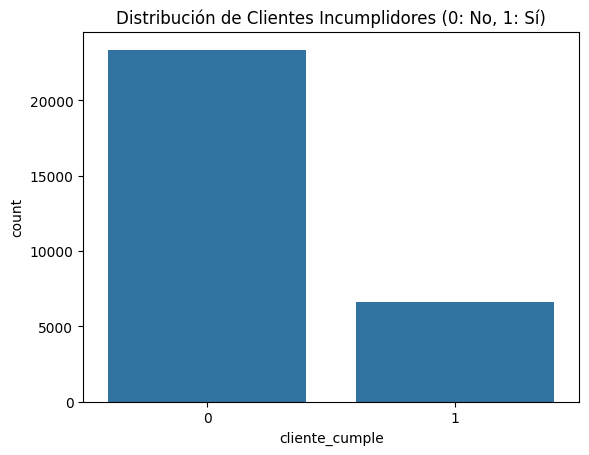

In [62]:


# Mostrar información concisa del DataFrame, incluyendo tipos de datos y valores no nulos
df.info()

# Generar estadísticas descriptivas de las columnas numéricas
print(df.describe())

# Mostrar la forma (número de filas y columnas) del DataFrame
df.shape
# Renombrar la columna objetivo para mayor claridad y facilidad de uso
df = df.rename(columns={'default.payment.next.month':'cliente_cumple'})



# Verificar la presencia de valores nulos en cada columna
df.isnull().sum()

# Analizar la distribución de la variable objetivo ('default')
sns.countplot(x='cliente_cumple', data=df)
plt.title('Distribución de Clientes Incumplidores (0: No, 1: Sí)')
plt.show()



In [53]:
# Análisis de variables categóricas (SEX, EDUCATION, MARRIAGE)
# Verificar los valores únicos para identificar posibles errores o valores inconsistentes
print("\nValores únicos en la columna 'EDUCATION':", df['EDUCATION'].unique())
print("Valores únicos en la columna 'MARRIAGE':", df['MARRIAGE'].unique())
print("Valores únicos en la columna 'SEX':", df['SEX'].unique())


Valores únicos en la columna 'EDUCATION': [2 1 3 5 4 6 0]
Valores únicos en la columna 'MARRIAGE': [1 2 3 0]
Valores únicos en la columna 'SEX': [2 1]


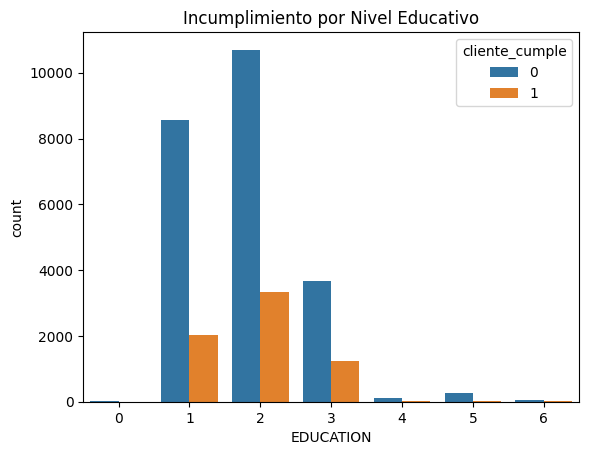

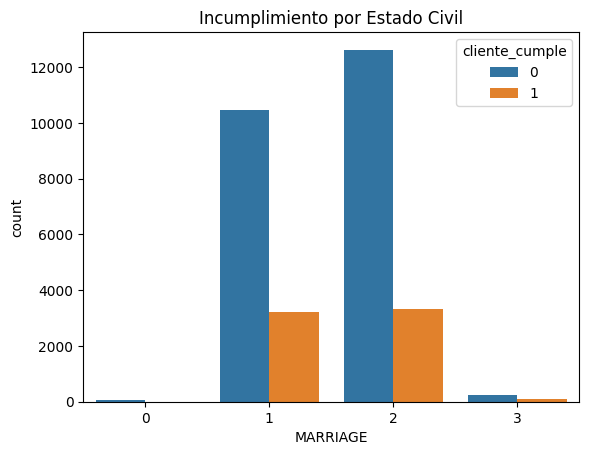

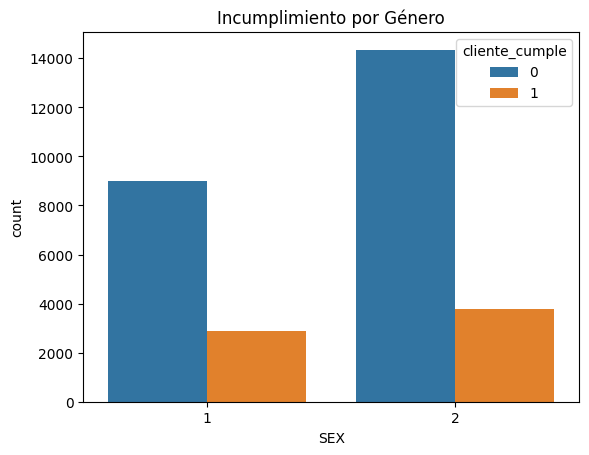

In [64]:
# Graficar la distribución de la variable objetivo por nivel educativo
sns.countplot(x='EDUCATION', hue='cliente_cumple', data=df)
plt.title('Incumplimiento por Nivel Educativo')
plt.show()

# Graficar la distribución de la variable objetivo por estado civil
sns.countplot(x='MARRIAGE', hue='cliente_cumple', data=df)
plt.title('Incumplimiento por Estado Civil')
plt.show()

# Graficar la distribución de la variable objetivo por género
sns.countplot(x='SEX', hue='cliente_cumple', data=df)
plt.title('Incumplimiento por Género')
plt.show()

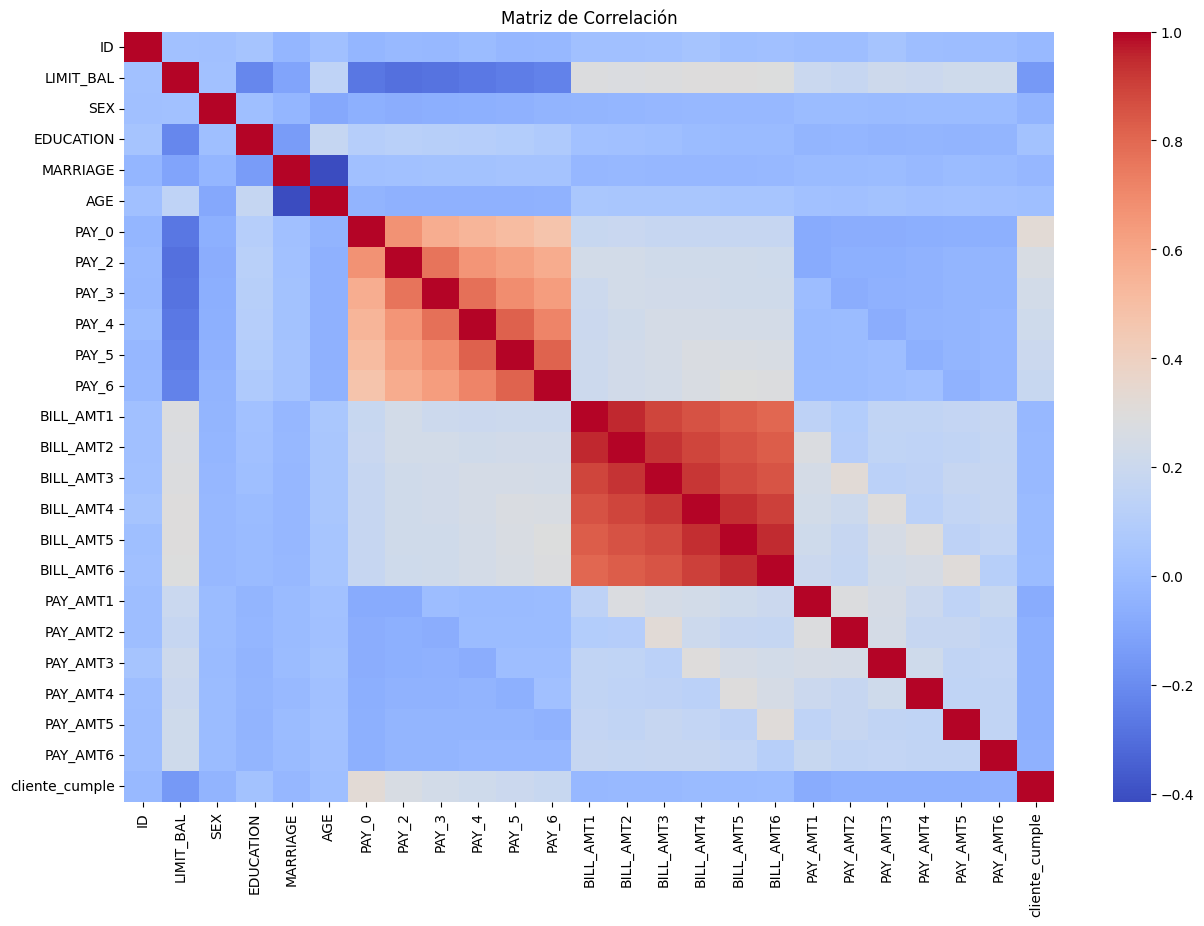

In [66]:

# Matriz de correlación para entender la relación entre variables numéricas
plt.figure(figsize=(15, 10))
# 'numeric_only=True' para evitar errores si hay columnas no numéricas que no se han procesado aún
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()
# Observese las columnas 'PAY_,BILLI_AMT' (historial de pagos), suelen tener una fuerte correlación con el incumplimiento.

# 3. Preprocesamiento de Datos

In [67]:
# Separar las características (X) de la variable objetivo (y)
X = df.drop('cliente_cumple', axis=1) # X contiene todas las columnas excepto 'cliente_cumple'
y = df['cliente_cumple']             # y contiene solo la columna 'cliente_cumple'

# Dividir los datos en conjuntos de entrenamiento y prueba
# test_size=0.2 indica que el 20% de los datos se usarán para prueba y el 80% para entrenamiento.
# random_state=42 asegura la reproducibilidad de la división.
# stratify=y es crucial para datasets desequilibrados: asegura que la proporción de clases en y_train y y_test sea similar a la del dataset original.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identificar tipos de columnas para el preprocesamiento
# Columnas categóricas (variables que representan categorías)
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']
# Columnas numéricas (todas las demás que no son categóricas ni la variable objetivo)
numerical_features = [col for col in X_train.columns if col not in categorical_features]

# Limpiar valores anómalos en 'EDUCATION' y 'MARRIAGE' antes del OneHotEncoder
# El dataset de UCI puede tener valores 0, 5, 6 en EDUCATION y 0 en MARRIAGE que no están bien documentados.
# Una estrategia es remapearlos a una categoría 'Other' o 'Unknown', aquí mapeamos a 4 para EDUCATION y 3 para MARRIAGE
def clean_education(edu):
    if edu == 0 or edu == 5 or edu == 6:
        return 4 # Mapear a una categoría 'Otros'
    else:
        return edu

def clean_marriage(marr):
    if marr == 0:
        return 3 # Mapear a una categoría 'Otros'
    else:
        return marr

# Aplicar las funciones de limpieza a los conjuntos de entrenamiento y prueba
X_train['EDUCATION'] = X_train['EDUCATION'].apply(clean_education)
X_test['EDUCATION'] = X_test['EDUCATION'].apply(clean_education)
X_train['MARRIAGE'] = X_train['MARRIAGE'].apply(clean_marriage)
X_test['MARRIAGE'] = X_test['MARRIAGE'].apply(clean_marriage)

# Convertir las columnas categóricas a tipo 'category' para que OneHotEncoder las maneje correctamente
# Esto es opcional si ya estás seguro de que ColumnTransformer las identificará bien, pero es buena práctica.
X_train[categorical_features] = X_train[categorical_features].astype('category')
X_test[categorical_features] = X_test[categorical_features].astype('category')

# Crear el preprocesador usando ColumnTransformer
# Esto permite aplicar diferentes transformaciones a diferentes columnas.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features), # 'num': Aplicar StandardScaler a las columnas numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) # 'cat': Aplicar OneHotEncoder a las columnas categóricas
                                                                              # handle_unknown='ignore' previene errores si aparecen categorías nuevas en el conjunto de prueba
    ])


# 4. Construcción y Evaluación de Modelos

--- Evaluando Regresión Logística ---

Resultados de Regresión Logística:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.76      0.61      0.62      6000
weighted avg       0.79      0.81      0.77      6000

ROC AUC: 0.7100


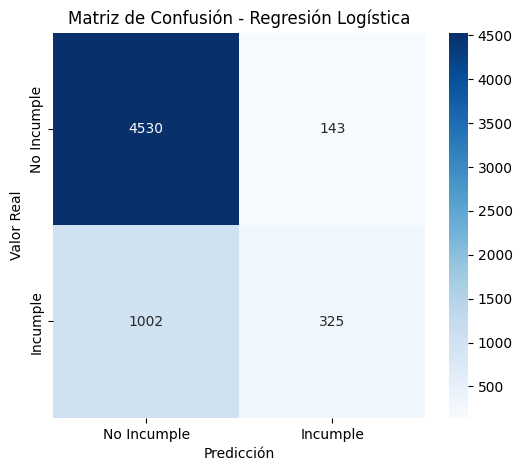

In [70]:
# --- 1. Modelo de Regresión Logística ---
print("--- Evaluando Regresión Logística ---")
# Crear un pipeline que primero preprocese los datos y luego aplique el clasificador
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor), # Paso 1: Preprocesamiento de datos
                              ('classifier', LogisticRegression(solver='liblinear', random_state=42))]) # Paso 2: Modelo de Regresión Logística
                                                                                                        # solver='liblinear' es bueno para datasets pequeños y binarios
                                                                                                        # random_state para reproducibilidad

# Entrenar el pipeline con los datos de entrenamiento
pipeline_lr.fit(X_train, y_train)

# Realizar predicciones sobre el conjunto de prueba
y_pred_lr = pipeline_lr.predict(X_test)
# Predecir probabilidades para la clase positiva (útil para ROC AUC)
y_prob_lr = pipeline_lr.predict_proba(X_test)[:, 1]

# Evaluar el modelo y mostrar las métricas
print("\nResultados de Regresión Logística:")
print(classification_report(y_test, y_pred_lr)) # Muestra precision, recall, f1-score y soporte para cada clase
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_lr):.4f}") # Área bajo la curva ROC (métrica importante para desequilibrio de clases)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Incumple', 'Incumple'], yticklabels=['No Incumple', 'Incumple'])
plt.title('Matriz de Confusión - Regresión Logística')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()






--- Evaluando Random Forest ---

Resultados de Random Forest:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4673
           1       0.65      0.37      0.47      1327

    accuracy                           0.82      6000
   macro avg       0.74      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000

ROC AUC: 0.7594


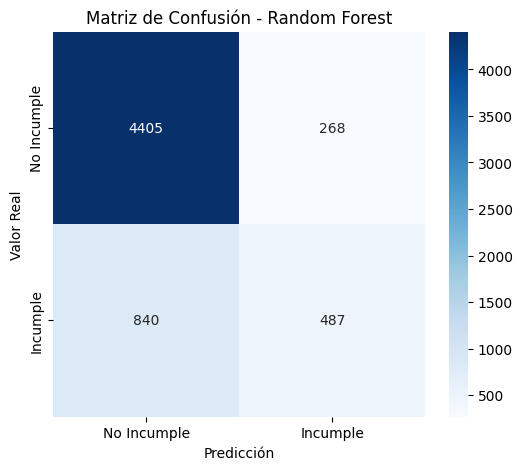

In [71]:

# --- 2. Modelo de Random Forest ---
print("\n--- Evaluando Random Forest ---")
# Crear un pipeline para Random Forest
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))]) # Modelo Random Forest

# Entrenar el pipeline
pipeline_rf.fit(X_train, y_train)

# Realizar predicciones y obtener probabilidades
y_pred_rf = pipeline_rf.predict(X_test)
y_prob_rf = pipeline_rf.predict_proba(X_test)[:, 1]

# Evaluar el modelo
print("\nResultados de Random Forest:")
print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_rf):.4f}")

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Incumple', 'Incumple'], yticklabels=['No Incumple', 'Incumple'])
plt.title('Matriz de Confusión - Random Forest')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

5. Optimización de Hiperparámetros (Recomendado)

In [ ]:
# Definir la cuadrícula de parámetros a probar para Random Forest
# Los nombres de los parámetros deben seguir el formato 'nombre_paso__nombre_parametro' del pipeline
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300], # Número de árboles en el bosque
    'classifier__max_depth': [10, 20, None],   # Profundidad máxima de los árboles (None significa sin límite)
    'classifier__min_samples_split': [2, 5, 10] # Número mínimo de muestras requeridas para dividir un nodo interno
}

# Configurar GridSearchCV
# estimator: el pipeline que se va a optimizar
# param_grid: la cuadrícula de parámetros a explorar
# cv: número de pliegues para la validación cruzada (5 significa 5-fold cross-validation)
# scoring: métrica a optimizar (roc_auc es bueno para problemas desequilibrados)
# n_jobs=-1: usa todos los núcleos de la CPU disponibles para procesamiento en paralelo
# verbose=1: muestra mensajes de progreso
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# Ejecutar la búsqueda en cuadrícula en los datos de entrenamiento
grid_search_rf.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print(f"\nMejores parámetros para Random Forest: {grid_search_rf.best_params_}")
# Mostrar la mejor puntuación de ROC AUC obtenida durante la validación cruzada
print(f"Mejor ROC AUC en entrenamiento (CV): {grid_search_rf.best_score_:.4f}")

# Realizar predicciones y obtener probabilidades con el mejor modelo encontrado por GridSearchCV
y_pred_tuned_rf = grid_search_rf.predict(X_test)
y_prob_tuned_rf = grid_search_rf.predict_proba(X_test)[:, 1]

# Evaluar el modelo de Random Forest optimizado
print("\nResultados de Random Forest (Optimizado con GridSearchCV):")
print(classification_report(y_test, y_pred_tuned_rf))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_tuned_rf):.4f}")

# Visualizar la matriz de confusión del modelo optimizado
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_tuned_rf), annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Incumple', 'Incumple'], yticklabels=['No Incumple', 'Incumple'])
plt.title('Matriz de Confusión - Random Forest (Optimizado)')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

Fitting 5 folds for each of 27 candidates, totalling 135 fits
